# Final Project
# EDA

In [45]:
import os, gc, math, time, datetime
import numpy as np
import seaborn
from itertools import product

import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd 
import sklearn
import lightgbm as lgb
import scipy.sparse 

for p in [np, pd, sklearn, scipy, lgb]:
    print (p.__name__, p.__version__)

numpy 1.15.4
pandas 0.20.3
sklearn 0.19.0
scipy 0.19.1
lightgbm 2.3.1


In [40]:
def downcast_dtypes(df):
    '''
        Changes column types in the dataframe: 
                
                `float64` type to `float32`
                `int64`   type to `int32`
    '''
    
    # Select columns to downcast
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype == "int64"]
    
    # Downcast
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols]   = df[int_cols].astype(np.int32)
    
    return df

def remove_from_list(A, B):
    for b in B:
        A.remove(b)
    return A

In [3]:
# Load data
DATA_FOLDER = '../readonly/final_project_data/'

sales           = pd.read_csv(os.path.join(DATA_FOLDER, 'sales_train.csv.gz'))
items           = pd.read_csv(os.path.join(DATA_FOLDER, 'items.csv'))
item_categories = pd.read_csv(os.path.join(DATA_FOLDER, 'item_categories.csv'))
shops           = pd.read_csv(os.path.join(DATA_FOLDER, 'shops.csv'))

In [4]:
# Print the shape of the loaded dataframes
print(sales.shape)
print(items.shape)
print(item_categories.shape)
print(shops.shape)

(2935849, 6)
(22170, 3)
(84, 2)
(60, 2)


## Print first rows

In [5]:
sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [6]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [7]:
item_categories.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [8]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [9]:
test = pd.read_csv(os.path.join(DATA_FOLDER, 'test.csv.gz'))
print(test.shape)
test.head()

(214200, 3)


,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [41]:
index_cols = ['shop_id', 'item_id', 'date_block_num']
index_cols_shop = ['shop_id', 'date_block_num']
index_cols_item = ['item_id', 'date_block_num']
index_cols_category = ['item_category_id', 'date_block_num']

data_cols = ['item_price', 'item_cnt_day']
future_index_cols = ['shop_id','item_id']

target_cols = ['target', 'revenue', 'target_shop', 'revenue_per_shop', 'target_item', 'revenue_per_item', 'target_category', 'revenue_per_category', 'target_item_price']

In [11]:
# Prepare data with all the sales of train and test
# the test sales are unknown so equal to zero
# the test data belongs to date_block_num 34, because of the competition rules

sales = sales[index_cols + data_cols].copy()
sales_test = test[future_index_cols].copy()
sales_test['date_block_num'] = 34
sales_test['item_price'] = 0
sales_test['item_cnt_day'] = 0
all_sales = sales.append(sales_test, ignore_index=True)

In [12]:
all_sales.head()

,shop_id,item_id,date_block_num,item_price,item_cnt_day
0,59,22154,0,999.00,1.0
1,25,2552,0,899.00,1.0
2,25,2552,0,899.00,-1.0
3,25,2554,0,1709.05,1.0
4,25,2555,0,1099.00,1.0


In [13]:
# Add revenue (maybe will be useful)
all_sales['revenue'] = all_sales['item_price'] * all_sales['item_cnt_day']

# Add item category (maybe will be useful)
items2 = items[['item_id','item_category_id']]
all_sales = all_sales.join(items2.set_index('item_id'), on='item_id')

In [14]:
# For every month we create a grid from all shops/items combinations from that month
grid = [] 
for block_num in all_sales['date_block_num'].unique():
    cur_shops = all_sales[all_sales['date_block_num']==block_num]['shop_id'].unique()
    cur_items = all_sales[all_sales['date_block_num']==block_num]['item_id'].unique()
    grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))

#turn the grid into pandas dataframe
grid = pd.DataFrame(np.vstack(grid), columns = index_cols,dtype=np.int32)

In [15]:
# Create base aggregations

# get aggregated values for (shop_id, item_id, month)
agg_dict = {'item_cnt_day':{'target':'sum'}, 'revenue':{'revenue':'sum'}}
gb = all_sales.groupby(index_cols,as_index=False).agg(agg_dict)
gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values] #fix column names

# join aggregated data to the grid
all_data = pd.merge(grid,gb,how='left',on=index_cols).fillna(0)

# sort the data
all_data.sort_values(['date_block_num','shop_id','item_id'],inplace=True)

# add shop-month aggregates
agg_dict = {'item_cnt_day':{'target_shop':'sum'}, 'revenue':{'revenue_per_shop':'sum'}}
gb = all_sales.groupby(index_cols_shop,as_index=False).agg(agg_dict)
gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values]
all_data = pd.merge(all_data, gb, how='left', on=index_cols_shop).fillna(0)

# add item-month aggregates
agg_dict = {'item_cnt_day':{'target_item':'sum'}, 'revenue':{'revenue_per_item':'sum'}}
gb = all_sales.groupby(index_cols_item,as_index=False).agg(agg_dict)
gb.columns = [col[0] if col[-1] == '' else col[-1] for col in gb.columns.values]
all_data = pd.merge(all_data, gb, how='left', on=index_cols_item).fillna(0)

# add itemcategory-month aggregates
agg_dict = {'item_cnt_day':{'target_category':'sum'}, 'revenue':{'revenue_per_category':'sum'}}
gb = all_sales.groupby(index_cols_category,as_index=False).agg(agg_dict)
gb.columns = [col[0] if col[-1] == '' else col[-1] for col in gb.columns.values]
all_data = pd.merge(all_data, items2, how='left', on='item_id').fillna(0)
all_data = pd.merge(all_data, gb, how='left', on=index_cols_category).fillna(0)

# add item-month average price
all_data['target_item_price'] = all_data['revenue_per_item'] / all_data['target_item']
all_data['target_item_price'] = all_data['target_item_price'].replace(-np.inf, np.nan)
all_data['target_item_price'] = all_data['target_item_price'].replace(np.inf, np.nan)
all_data['target_item_price'] = all_data['target_item_price'].fillna(0)

# Downcast dtypes from 64 to 32 bit to save memory
all_data = downcast_dtypes(all_data)

D:\anaconda3\anaconda3\envs\scipy0.19.1\lib\site-packages\pandas\core\groupby.py:4036: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


In [16]:
all_data.head()

,shop_id,item_id,date_block_num,target,revenue,target_shop,revenue_per_shop,target_item,revenue_per_item,item_category_id,target_category,revenue_per_category,target_item_price
0,0,19,0,0.0,0.0,5578.0,2966412.0,1.0,28.000000,40,33489.0,8667237.0,28.000000
1,0,27,0,0.0,0.0,5578.0,2966412.0,7.0,16275.000000,19,8983.0,14095792.0,2325.000000
2,0,28,0,0.0,0.0,5578.0,2966412.0,8.0,4392.000000,30,22216.0,10012800.0,549.000000
3,0,29,0,0.0,0.0,5578.0,2966412.0,4.0,9387.000000,23,4150.0,7662671.5,2346.750000
4,0,32,0,6.0,1326.0,5578.0,2966412.0,299.0,101515.859375,40,33489.0,8667237.0,339.517914


In [17]:
train = all_data[all_data['date_block_num'] < 34]

D:\anaconda3\anaconda3\envs\scipy0.19.1\lib\site-packages\pandas\plotting\_tools.py:308: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
D:\anaconda3\anaconda3\envs\scipy0.19.1\lib\site-packages\pandas\plotting\_tools.py:308: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
D:\anaconda3\anaconda3\envs\scipy0.19.1\lib\site-packages\pandas\plotting\_tools.py:314: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
D:\anaconda3\anaconda3\envs\scipy0.19.1\lib\site-pack

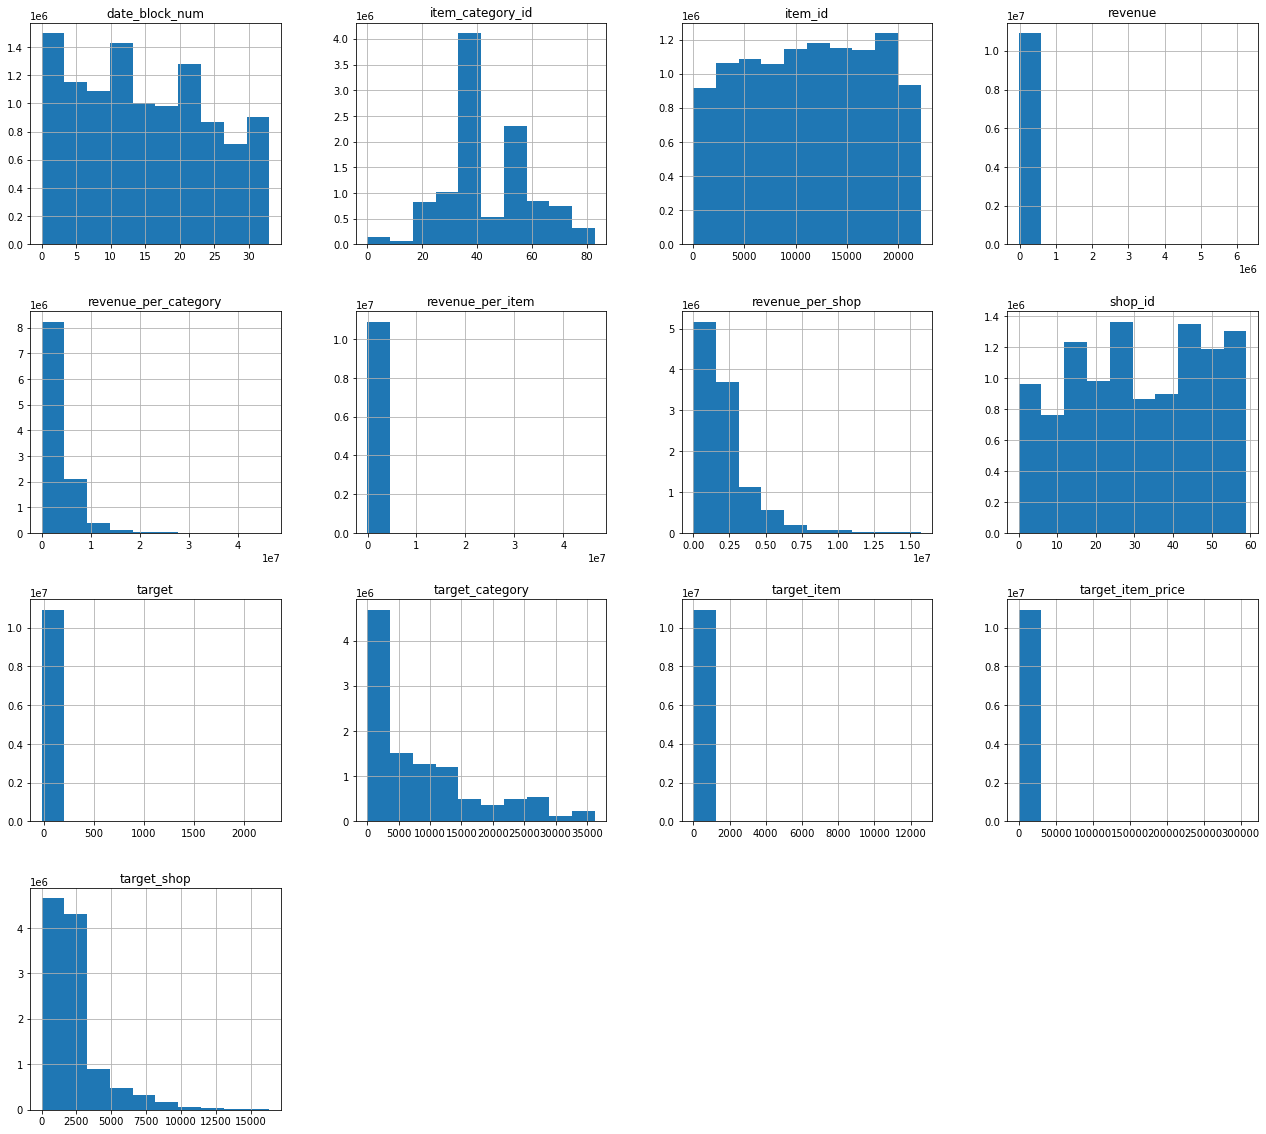

In [18]:
# Data histograms
p = train.hist(figsize = (22,20))
plt.show()

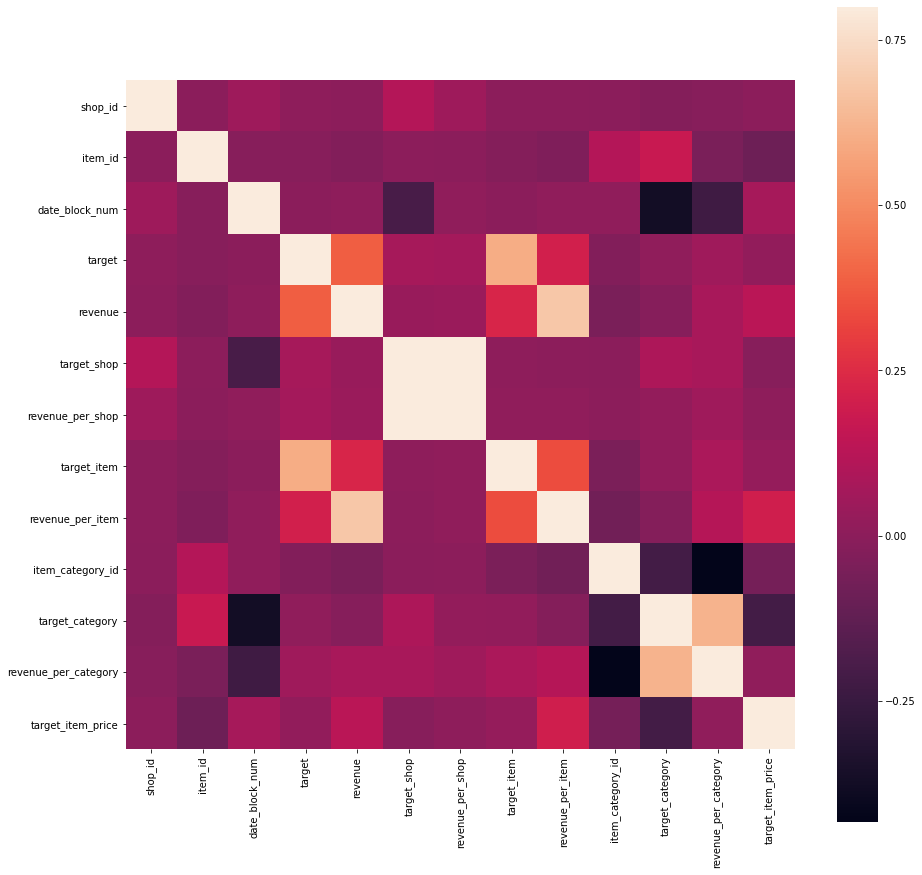

In [19]:
# Correlations
corr_mat = train.corr()
fig = plt.figure(figsize = (15,15))

p = seaborn.heatmap(corr_mat, vmax = .8, square = True)
plt.show()

The target is highly correlated with the item and the revenue but not much with the shop

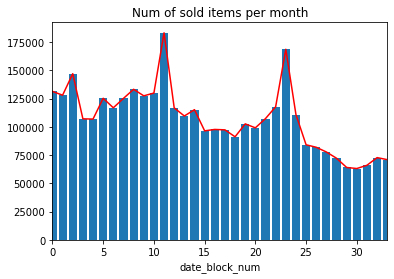

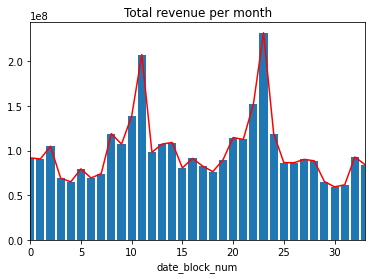

In [20]:
s = train.groupby(by='date_block_num')['target'].sum()
p = s.plot(color='red')
p = plt.bar(s.index,s)
p = plt.title('Num of sold items per month')
p = plt.show()

s = train.groupby(by='date_block_num')['revenue'].sum()
p = s.plot(color='red')
p = plt.bar(s.index,s)
p = plt.title('Total revenue per month')
p = plt.show()

# Advanced Features I: mean encodings

In [21]:
global_mean = all_data['item_category_id'].mean()
    
cumsum = all_data.groupby('item_category_id')['item_category_id'].cumsum() - all_data['item_category_id']
cumcnt = all_data.groupby('item_category_id').cumcount()

all_data['item_category_id_enc'] = cumsum / cumcnt
all_data['item_category_id_enc'].fillna(global_mean, inplace=True)

corr = np.corrcoef(all_data['item_category_id'].values, all_data['item_category_id_enc'].values)[0][1]
corr

0.9999901243319362

In [22]:
# List of columns that we will use to create lags
cols_to_lag = ['target', 'target_shop']
shift_range = [1, 2, 3, 4, 5, 12]

In [23]:
for month_shift in shift_range:
    train_shift = all_data[index_cols + cols_to_lag].copy()
    
    train_shift['date_block_num'] = train_shift['date_block_num'] + month_shift
    
    foo = lambda x: '{}_lag_{}'.format(x, month_shift) if x in cols_to_lag else x
    train_shift = train_shift.rename(columns=foo)

    all_data = pd.merge(all_data, train_shift, on=index_cols, how='left').fillna(0)
    
    del train_shift

NameError: name 'train_shift' is not defined

In [27]:
# Don't use old data from year 2013
all_data = all_data[all_data['date_block_num'] >= 12]

all_data = downcast_dtypes(all_data)
res = gc.collect()

In [28]:
all_data.head()

,shop_id,item_id,date_block_num,target,revenue,target_shop,revenue_per_shop,target_item,revenue_per_item,item_category_id,...,target_lag_2,target_shop_lag_2,target_lag_3,target_shop_lag_3,target_lag_4,target_shop_lag_4,target_lag_5,target_shop_lag_5,target_lag_12,target_shop_lag_12
4488756,2,27,12,0.0,0.0,890.0,1032722.0,1.0,998.0,19,...,0.0,862.0,0.0,795.0,0.0,945.0,0.0,875.0,1.0,1146.0
4488757,2,30,12,0.0,0.0,890.0,1032722.0,58.0,9802.0,40,...,0.0,862.0,0.0,795.0,0.0,945.0,0.0,875.0,0.0,0.0
4488758,2,31,12,0.0,0.0,890.0,1032722.0,15.0,7485.0,37,...,0.0,862.0,0.0,795.0,0.0,945.0,0.0,875.0,0.0,0.0
4488759,2,32,12,1.0,119.0,890.0,1032722.0,84.0,12190.0,40,...,0.0,862.0,0.0,795.0,0.0,945.0,0.0,875.0,0.0,1146.0
4488760,2,33,12,1.0,199.0,890.0,1032722.0,42.0,8296.0,37,...,2.0,862.0,0.0,795.0,0.0,945.0,0.0,875.0,1.0,1146.0


In [29]:
print(all_data.dtypes)

shop_id                   int32
item_id                   int32
date_block_num            int32
target                  float32
revenue                 float32
target_shop             float32
revenue_per_shop        float32
target_item             float32
revenue_per_item        float32
item_category_id          int32
target_category         float32
revenue_per_category    float32
target_item_price       float32
item_category_id_enc    float32
target_lag_1            float32
target_shop_lag_1       float32
target_lag_2            float32
target_shop_lag_2       float32
target_lag_3            float32
target_shop_lag_3       float32
target_lag_4            float32
target_shop_lag_4       float32
target_lag_5            float32
target_shop_lag_5       float32
target_lag_12           float32
target_shop_lag_12      float32
dtype: object


In [32]:
# Save features
all_data.to_hdf('features/features.h5', key='df', mode='w', complib='zlib') #overwrite

# TUNING MODELS

In [49]:
from sklearn import feature_extraction
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, ElasticNet, ElasticNetCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.tree import DecisionTreeRegressor

In [36]:
# Load features
all_data = pd.read_hdf('features/features.h5', 'df')

In [42]:
# Remove index and targets (no leakages)
fit_cols = list(all_data.columns)
fit_cols = remove_from_list(fit_cols, index_cols)
fit_cols = remove_from_list(fit_cols, target_cols)

In [43]:
# Dataset split
# The dataset has a timeline, get last month of train as validation data.
test_month = max(all_data['date_block_num']) 

val_month = max(all_data['date_block_num']) - 1    

dates = all_data['date_block_num']
dates_train  = dates[dates <  val_month]
dates_val = dates[dates == val_month]
dates_test  = dates[dates == test_month]

X_train = all_data[dates <  val_month][fit_cols]
X_val = all_data[dates == val_month][fit_cols]
X_test =  all_data[dates == test_month][fit_cols]

y_train = all_data.loc[dates <  val_month, 'target'].values
y_val = all_data.loc[dates == val_month, 'target'].values
y_test =  all_data.loc[dates == test_month, 'target'].values

In [51]:
# True target values are clipped into [0,20] range.
target_range = [0, 20]

def rmse_score(y_true, y_pred):
    return math.sqrt(mean_squared_error(y_true, y_pred))

## Linear Regressor

In [46]:
# Fit
t_start = time.time()
lr_model = LinearRegression()
res = lr_model.fit(X_train.values, y_train) 
print("elapsed time: %.2f" % (time.time() - t_start))

elapsed time: 24.02


In [54]:
# Score
pred_train_lr = lr_model.predict(X_train.values).clip(*target_range)
print('Train RMSE for linear regression is %f' % rmse_score(y_train.clip(*target_range), pred_train_lr))

pred_val_lr = lr_model.predict(X_val.values).clip(*target_range)
print('Validation RMSE for linear regression is %f' % rmse_score(y_val.clip(*target_range), pred_val_lr))

Train RMSE for linear regression is 0.970850
Validation RMSE for linear regression is 1.006492


## LightGBM

In [55]:
lgb_params = {
               'feature_fraction': 0.75,
               'metric': 'rmse',
               'nthread':1, 
               'min_data_in_leaf': 2**7, 
               'bagging_fraction': 0.75, 
               'learning_rate': 0.03, 
               'objective': 'mse', 
               'bagging_seed': 2**7, 
               'num_leaves': 2**7,
               'bagging_freq':1,
               'verbose':0 
              }

lgb_iterations = 1000

In [56]:
# Fit with early stopping to check the iterations (tuning)
model_early = lgb.train(lgb_params, lgb.Dataset(X_train, label=y_train.clip(*target_range)), 
                        num_boost_round=lgb_iterations,
                        valid_sets=[lgb.Dataset(X_val, label=y_val.clip(*target_range))], 
                        valid_names=['val'], 
                        early_stopping_rounds=3)

[1]	val's rmse: 1.12513
Training until validation scores don't improve for 3 rounds
[2]	val's rmse: 1.11637
[3]	val's rmse: 1.10599
[4]	val's rmse: 1.0959
[5]	val's rmse: 1.08639
[6]	val's rmse: 1.07945
[7]	val's rmse: 1.07109
[8]	val's rmse: 1.06291
[9]	val's rmse: 1.05548
[10]	val's rmse: 1.04815
[11]	val's rmse: 1.04276
[12]	val's rmse: 1.03631
[13]	val's rmse: 1.03034
[14]	val's rmse: 1.02578
[15]	val's rmse: 1.02021
[16]	val's rmse: 1.01493
[17]	val's rmse: 1.01006
[18]	val's rmse: 1.00552
[19]	val's rmse: 1.00221
[20]	val's rmse: 0.998074
[21]	val's rmse: 0.994998
[22]	val's rmse: 0.991287
[23]	val's rmse: 0.98854
[24]	val's rmse: 0.985151
[25]	val's rmse: 0.981982
[26]	val's rmse: 0.97912
[27]	val's rmse: 0.976365
[28]	val's rmse: 0.973688
[29]	val's rmse: 0.97208
[30]	val's rmse: 0.970383
[31]	val's rmse: 0.968151
[32]	val's rmse: 0.966002
[33]	val's rmse: 0.96411
[34]	val's rmse: 0.96229
[35]	val's rmse: 0.960463
[36]	val's rmse: 0.958879
[37]	val's rmse: 0.957409
[38]	val's r

In [57]:
# Score
pred_train_lgb = model_early.predict(X_train.values).clip(*target_range)
print('Train RMSE for LightGBM is %f' % rmse_score(y_train.clip(*target_range), pred_train_lgb))

pred_val_lgb = model_early.predict(X_val.values).clip(*target_range)
print('Validation RMSE for LightGBM is %f' % rmse_score(y_val.clip(*target_range), pred_val_lgb))

Train RMSE for LightGBM is 0.882189
Validation RMSE for LightGBM is 0.939297


In [58]:
del(model_early)
gc.collect()

9846

In [59]:
# Chosen parameters for LightGBM
lgb_iterations = 75

# Fit to train
print(datetime.datetime.now())
t_start = time.time()
lgb_model = lgb.train(lgb_params, 
                  lgb.Dataset(X_train, label=y_train.clip(*target_range)), 
                  num_boost_round=lgb_iterations)
print("elapsed time: %.2f" % (time.time() - t_start))

2020-08-16 16:07:22.423318
elapsed time: 129.89


In [60]:
# Score
pred_train_lgb = lgb_model.predict(X_train.values).clip(*target_range)
print('Train RMSE for LightGBM is %f' % rmse_score(y_train.clip(*target_range), pred_train_lgb))

pred_val_lgb = lgb_model.predict(X_val.values).clip(*target_range)
print('Validation RMSE for LightGBM is %f' % rmse_score(y_val.clip(*target_range), pred_val_lgb))

Train RMSE for LightGBM is 0.883985
Validation RMSE for LightGBM is 0.939721


# ElasticNet

In [79]:
def get_en_params(alpha=1.0, l1_ratio=0.5, max_iter=1000):
    return {
                 'max_iter': max_iter,
                 'random_state': 0, # Changing this could generate ensembling options
    
                 'alpha': alpha,
                 'l1_ratio': l1_ratio,

                 'tol': 0.0001,
                 'fit_intercept': True,
                 'normalize': False,
                 'positive': False,
                 'precompute': False,
                 'selection': 'cyclic',
                 'copy_X': True,
                 'warm_start': False
            }

In [80]:
# Default params
en_params = get_en_params()

# Fit to train with default parameters
t_start = time.time()
en_model = ElasticNet()
en_model = en_model.set_params(**en_params)
en_model = en_model.fit(X_train.values, y_train) 
print("elapsed time: %.2f" % (time.time() - t_start))

elapsed time: 15.14


In [81]:
# Score
pred_train_en = en_model.predict(X_train.values).clip(*target_range)
print('Train RMSE for EN is %f' % rmse_score(y_train.clip(*target_range), pred_train_en))

pred_val_en = en_model.predict(X_val.values).clip(*target_range)
print('Validation RMSE for EN is %f' % rmse_score(y_val.clip(*target_range), pred_val_en))

Train RMSE for EN is 0.958512
Validation RMSE for EN is 0.992922


# Ensembling

The stacking is the selected approach, combine two 1-st level models (LR and LGB) with a 2-nd level simple model (LinearConvexMix or LinearRegressor)
The features will be created using the lectures f) KFold scheme in time series, with T=1_month and M=Total_months-6.

## Train meta features

In [61]:
# The six last months are the chunks for folding.
last_blocks = [27, 28, 29, 30, 31, 32]
dates_train_level2 = dates_train[dates_train.isin(last_blocks)]

In [64]:
# That is how we get target for the 2nd level dataset
y_train_level2 = y_train[dates_train.isin(last_blocks)]

# And here we create 2nd level feeature matrix, init it with zeros first
X_train_level2 = np.zeros([y_train_level2.shape[0], 2])

# Now fill `X_train_level2` with metafeatures
for cur_block_num in last_blocks:
    
    print(cur_block_num, end='')
    
    '''
        1. Split `X_train` into parts
           Remember, that corresponding dates are stored in `dates_train` 
        2. Fit linear regression 
        3. Fit LightGBM and put predictions          
        4. Store predictions from 2. and 3. in the right place of `X_train_level2`. 
           You can use `dates_train_level2` for it
           Make sure the order of the meta-features is the same as in `X_test_level2`
    '''      

    X_block_train = X_train.loc[dates_train <  cur_block_num]
    y_block_train = y_train[dates_train < cur_block_num]
    X_block_val = X_train[dates_train == cur_block_num]
    y_block_val = y_train[dates_train == cur_block_num]
    
    print(':  X_block_train.shape={}'.format(X_block_train.shape), end='')
    print(',  X_block_val.shape={}'.format(X_block_val.shape), end='')
    print(',   Total Size={}'.format(X_block_train.shape[0] + X_block_val.shape[0]), end='')
    print()
    
    lr_model.fit(X_block_train, y_block_train)
    X_train_level2[dates_train_level2 == cur_block_num, 0] = lr_model.predict(X_block_val.values).clip(*target_range)
    
    model = lgb.train(lgb_params, 
                  lgb.Dataset(X_block_train, label=y_block_train.clip(*target_range)), 
                  num_boost_round=lgb_iterations)
    X_train_level2[dates_train_level2 == cur_block_num, 1] = model.predict(X_block_val).clip(*target_range)

27:  X_block_train.shape=(4810730, 14),  X_block_val.shape=(257372, 14),   Total Size=5068102
28:  X_block_train.shape=(5068102, 14),  X_block_val.shape=(232452, 14),   Total Size=5300554
29:  X_block_train.shape=(5300554, 14),  X_block_val.shape=(224288, 14),   Total Size=5524842
30:  X_block_train.shape=(5524842, 14),  X_block_val.shape=(228889, 14),   Total Size=5753731
31:  X_block_train.shape=(5753731, 14),  X_block_val.shape=(214536, 14),   Total Size=5968267
32:  X_block_train.shape=(5968267, 14),  X_block_val.shape=(218655, 14),   Total Size=6186922


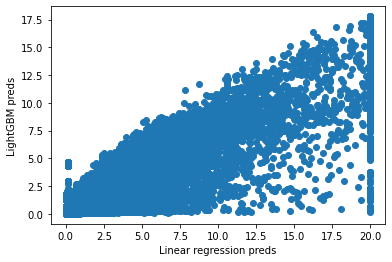

In [65]:
# Check if the 1st level models are uncorrelated enough
plt.scatter(X_train_level2[:,0], X_train_level2[:,1],)
plt.xlabel('Linear regression preds')
plt.ylabel('LightGBM preds')
plt.show()

## Validation meta features

In [67]:
# fit models and create the predictions
lr_model.fit(X_train, y_train)
pred_lr = lr_model.predict(X_val).clip(*target_range)

lgb_model = lgb.train(lgb_params, 
                  lgb.Dataset(X_train, label=y_train.clip(*target_range)), 
                  num_boost_round=lgb_iterations)
pred_lgb = lgb_model.predict(X_val).clip(*target_range)

# concatenate predictions to get the meta features
X_val_level2 = np.c_[pred_lr, pred_lgb] 
print(X_val_level2.shape)
print(X_val_level2[:3])

(238172, 2)
[[0.08544651 0.06277323]
 [0.08717979 0.06277323]
 [0.49919918 0.21941799]]


## Stack the models

### Check linear convex mix

Simple linear convex mix: mix=α⋅linreg_prediction+(1−α)⋅lgb_prediction

In [68]:
alphas_to_try = np.linspace(0, 1, 1001)

def lcmix_predict(X, alpha):
    return alpha*X[:,0] + (1-alpha)*X[:,1]

best_alpha = -1
r2_train_simple_mix = -1e10
for alpha in alphas_to_try:
    lcmix_preds = lcmix_predict(X_train_level2, alpha)
    lcmix_preds = lcmix_preds.clip(*target_range)
    r2 = r2_score(y_train_level2, lcmix_preds)
    if r2 > r2_train_simple_mix:
        best_alpha = alpha
        r2_train_simple_mix = r2

print('Best alpha: %f; Corresponding r2 score on train: %f' % (best_alpha, r2_train_simple_mix))

Best alpha: 0.461000; Corresponding r2 score on train: 0.078322


In [69]:
lcmix_preds = lcmix_predict(X_val_level2, best_alpha)
print('Dev R-squared for simple mix is %f' % r2_score(y_val, lcmix_preds))
print('Dev RMSE for simple mix is %f' %  rmse_score(y_val.clip(*target_range), lcmix_preds))

Dev R-squared for simple mix is 0.046555
Dev RMSE for simple mix is 0.943529


### Check linear regression

In [75]:
# Create model
lr_model.fit(pd.DataFrame(X_train_level2), y_train_level2)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [78]:
# Score
pred_train_lr = lr_model.predict(pd.DataFrame(X_train_level2)).clip(*target_range)
print('Train RMSE for linear regression as 2nd level model is %f' % rmse_score(y_train_level2, pred_train_lr))

pred_val_lr = lr_model.predict(pd.DataFrame(X_val_level2)).clip(*target_range)
print('Validation RMSE for linear regression as 2nd level model is %f' % rmse_score(y_val.clip(*target_range), pred_val_lr))

Train RMSE for linear regression as 2nd level model is 3.874031
Validation RMSE for linear regression as 2nd level model is 1.109497


# Predictions for submission

In [71]:
# prepare all data

X_all = X_train.append(X_val)
y_all = np.concatenate([y_train, y_val])
print(len(X_all),len(y_all),len(X_test),'\n')

# fit 1-st level models and create the predictions

lr_model.fit(X_all, y_all)
pred_lr = lr_model.predict(X_test).clip(*target_range)
print(len(pred_lr),"\n")

lgb_model = lgb.train(lgb_params, 
                  lgb.Dataset(X_all, label=y_all.clip(*target_range)), 
                  num_boost_round=lgb_iterations)
pred_lgb = lgb_model.predict(X_test).clip(*target_range)
print(len(pred_lgb),"\n")

# concatenate predictions to get the meta features for stacking

X_all_level2 = np.c_[pred_lr, pred_lgb] 
print(X_all_level2.shape)

# and get the submission preds
submission_preds = lcmix_predict(X_all_level2, best_alpha)

6425094 6425094 214200 

214200 

214200 

(214200, 2)


In [72]:
#Load test data to merge ID for submission
test = pd.read_csv(os.path.join(DATA_FOLDER, 'test.csv.gz'))

In [73]:
# Create submission dataframe
# Append to shop_id, item_id of test data segment
test_month = max(all_data['date_block_num']) 

assert test_month == 34

test_data = all_data[all_data['date_block_num'] == test_month][future_index_cols]
test_data['item_cnt_month'] = submission_preds

print(len(test_data), len(submission_preds), np.mean(all_data['target']), np.mean(submission_preds))

#Use test data to merge ID for submission
submission = test[['ID']+future_index_cols].merge(test_data, on=future_index_cols, how='left').fillna(0)

print(len(test_data), len(submission), np.mean(test_data['item_cnt_month']), np.mean(submission['item_cnt_month']))

214200 214200 0.31411067 0.29688996779829546
214200 214200 0.29688996779829546 0.29688996779829546


In [74]:
# Dump to file
submission_columns = ['ID','item_cnt_month']
submission_filename = './submissions/submission_stacking_lgb_and_lr_with_lcmix.csv'
submission[submission_columns].to_csv(submission_filename,header=True,index=False)

I get a fine grade 8/10. My public and private LB scores are: 0.979675 and 0.981642.

# Stacking EN and LGBM

In [82]:
# Train meta features

# That is how we get target for the 2nd level dataset
y_train_level2 = y_train[dates_train.isin(last_blocks)]

# And here we create 2nd level feeature matrix, init it with zeros first
X_train_level2 = np.zeros([y_train_level2.shape[0], 2])

# Now fill `X_train_level2` with metafeatures
for cur_block_num in last_blocks:
    
    print(cur_block_num, end='')
    
    '''
        1. Split `X_train` into parts
           Remember, that corresponding dates are stored in `dates_train` 
        2. Fit linear regression 
        3. Fit LightGBM and put predictions          
        4. Store predictions from 2. and 3. in the right place of `X_train_level2`. 
           You can use `dates_train_level2` for it
           Make sure the order of the meta-features is the same as in `X_test_level2`
    '''      

    X_block_train = X_train.loc[dates_train <  cur_block_num]
    y_block_train = y_train[dates_train < cur_block_num]
    X_block_val = X_train[dates_train == cur_block_num]
    y_block_val = y_train[dates_train == cur_block_num]
    
    print(':  X_block_train.shape={}'.format(X_block_train.shape), end='')
    print(',  X_block_val.shape={}'.format(X_block_val.shape), end='')
    print(',   Total Size={}'.format(X_block_train.shape[0] + X_block_val.shape[0]), end='')
    print()
    
    en_model.fit(X_block_train, y_block_train)
    X_train_level2[dates_train_level2 == cur_block_num, 0] = en_model.predict(X_block_val.values).clip(*target_range)
    
    model = lgb.train(lgb_params, 
                  lgb.Dataset(X_block_train, label=y_block_train.clip(*target_range)), 
                  num_boost_round=lgb_iterations)
    X_train_level2[dates_train_level2 == cur_block_num, 1] = model.predict(X_block_val).clip(*target_range)

27:  X_block_train.shape=(4810730, 14),  X_block_val.shape=(257372, 14),   Total Size=5068102
28:  X_block_train.shape=(5068102, 14),  X_block_val.shape=(232452, 14),   Total Size=5300554
29:  X_block_train.shape=(5300554, 14),  X_block_val.shape=(224288, 14),   Total Size=5524842
30:  X_block_train.shape=(5524842, 14),  X_block_val.shape=(228889, 14),   Total Size=5753731
31:  X_block_train.shape=(5753731, 14),  X_block_val.shape=(214536, 14),   Total Size=5968267
32:  X_block_train.shape=(5968267, 14),  X_block_val.shape=(218655, 14),   Total Size=6186922


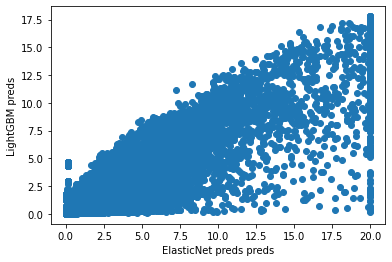

In [84]:
# Check if the 1st level models are uncorrelated enough
plt.scatter(X_train_level2[:,0], X_train_level2[:,1],)
plt.xlabel('ElasticNet preds preds')
plt.ylabel('LightGBM preds')
plt.show()

In [85]:
# Validation meta features

# fit models and create the predictions
en_model.fit(X_train, y_train)
pred_en = en_model.predict(X_val).clip(*target_range)

lgb_model = lgb.train(lgb_params, 
                  lgb.Dataset(X_train, label=y_train.clip(*target_range)), 
                  num_boost_round=lgb_iterations)
pred_lgb = lgb_model.predict(X_val).clip(*target_range)

# concatenate predictions to get the meta features
X_val_level2 = np.c_[pred_en, pred_lgb] 
print(X_val_level2.shape)
print(X_val_level2[:3])

(238172, 2)
[[0.09639225 0.06277323]
 [0.09639225 0.06277323]
 [0.44375501 0.21941799]]


In [86]:
# Stack the models

# Check linear convex mix

alphas_to_try = np.linspace(0, 1, 1001)

def lcmix_predict(X, alpha):
    return alpha*X[:,0] + (1-alpha)*X[:,1]

best_alpha = -1
r2_train_simple_mix = -1e10
for alpha in alphas_to_try:
    lcmix_preds = lcmix_predict(X_train_level2, alpha)
    lcmix_preds = lcmix_preds.clip(*target_range)
    r2 = r2_score(y_train_level2, lcmix_preds)
    if r2 > r2_train_simple_mix:
        best_alpha = alpha
        r2_train_simple_mix = r2

print('Best alpha: %f; Corresponding r2 score on train: %f' % (best_alpha, r2_train_simple_mix))

Best alpha: 0.510000; Corresponding r2 score on train: 0.078342


In [87]:
lcmix_preds = lcmix_predict(X_val_level2, best_alpha)
print('Dev R-squared for simple mix is %f' % r2_score(y_val, lcmix_preds))
print('Dev RMSE for simple mix is %f' %  rmse_score(y_val.clip(*target_range), lcmix_preds))

Dev R-squared for simple mix is 0.046606
Dev RMSE for simple mix is 0.943675


In [88]:
# Check linear regression

# Create model
lr_model.fit(pd.DataFrame(X_train_level2), y_train_level2)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [89]:
# Score
pred_train_lr = lr_model.predict(pd.DataFrame(X_train_level2)).clip(*target_range)
print('Train RMSE for linear regression as 2nd level model is %f' % rmse_score(y_train_level2, pred_train_lr))

pred_val_lr = lr_model.predict(pd.DataFrame(X_val_level2)).clip(*target_range)
print('Validation RMSE for linear regression as 2nd level model is %f' % rmse_score(y_val.clip(*target_range), pred_val_lr))

Train RMSE for linear regression as 2nd level model is 3.874187
Validation RMSE for linear regression as 2nd level model is 1.094778


In [90]:
# Predictions for submission

# prepare all data

X_all = X_train.append(X_val)
y_all = np.concatenate([y_train, y_val])
print(len(X_all),len(y_all),len(X_test),'\n')

# fit 1-st level models and create the predictions

en_model.fit(X_all, y_all)
pred_en = en_model.predict(X_test).clip(*target_range)
print(len(pred_en),"\n")

lgb_model = lgb.train(lgb_params, 
                  lgb.Dataset(X_all, label=y_all.clip(*target_range)), 
                  num_boost_round=lgb_iterations)
pred_lgb = lgb_model.predict(X_test).clip(*target_range)
print(len(pred_lgb),"\n")

# concatenate predictions to get the meta features for stacking

X_all_level2 = np.c_[pred_en, pred_lgb] 
print(X_all_level2.shape)

# and get the submission preds
submission_preds = lcmix_predict(X_all_level2, best_alpha)

6425094 6425094 214200 

214200 

214200 

(214200, 2)


In [91]:
#Load test data to merge ID for submission
test = pd.read_csv(os.path.join(DATA_FOLDER, 'test.csv.gz'))

In [92]:
# Create submission dataframe
# Append to shop_id, item_id of test data segment
test_month = max(all_data['date_block_num']) 

assert test_month == 34

test_data = all_data[all_data['date_block_num'] == test_month][future_index_cols]
test_data['item_cnt_month'] = submission_preds

print(len(test_data), len(submission_preds), np.mean(all_data['target']), np.mean(submission_preds))

#Use test data to merge ID for submission
submission = test[['ID']+future_index_cols].merge(test_data, on=future_index_cols, how='left').fillna(0)

print(len(test_data), len(submission), np.mean(test_data['item_cnt_month']), np.mean(submission['item_cnt_month']))

214200 214200 0.31411067 0.29622669626021964
214200 214200 0.29622669626021964 0.29622669626021964


In [93]:
# Dump to file
submission_columns = ['ID','item_cnt_month']
submission_filename = './submissions/submission_stacking_lgb_and_en_with_lcmix.csv'
submission[submission_columns].to_csv(submission_filename,header=True,index=False)

I get a fine grade 8/10. My public and private LB scores are: 0.980987 and 0.983114.